<a href="https://colab.research.google.com/github/nullPointerExcept10n/titanic-ML-project/blob/main/titanic_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# \<Table of Contents\>

## 1. Importing Libraries & Data
*   Importing Libraries
*   Importing Data

## 2. Preprocessing Data
* completing
* Creating
* converting
* Spliting data into "train" and "submit"

## 3. Data Analysis
* Profile Report
* Correlation Map
* Visualization

## 4. Model Selection
* Decision Tree Classifier
* Support Vector Classifier
* Ensamble Modeling

## 5. Model Building
* Decision Tree Classifier
* Support Vector Classifier
* Ensamble Modeling


> Processes of Model Building
* Cross Validation
* RFE
* Visualization
* Evaluating Accuracy

## 6. Model Evaluation




#  Importing Libraries & data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/titanicproject

/content/drive/MyDrive/titanicproject


In [3]:
#@title Importing Libraries
import sys 
import pandas as pd 
import matplotlib 
from mpl_toolkits import mplot3d
import numpy as np 
import scipy as sp 
import IPython
from IPython import display 
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')

#Model Algorithms
from sklearn.svm import NuSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.svm import SVC

#Model Helpers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
from pandas_profiling import ProfileReport
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [4]:
#@title Importing Data
train_raw = pd.read_csv('./train.csv')
submit_raw  = pd.read_csv('./test.csv')
full_raw = pd.concat([train_raw, submit_raw])
full_data = full_raw

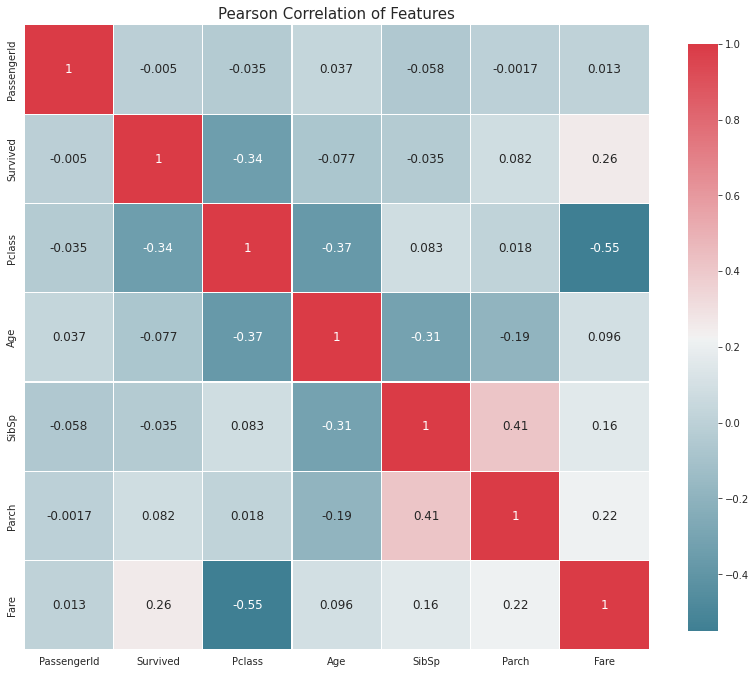

In [5]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_raw)

# Preprocessing Data

---


**4 C's of Data Preprocessing**


1. Correcting
2. Completing
3. Creating
4. Converting

We will preprocess our data by 1) correcting aberrant values and outliers, 2) completing missing information, 3) creating new features for analysis, and 4) converting fields to the correct format for calculations and presentation.



##1. Correcting
Find errors in Titanic dataset. 

###Correcting errors
While there weren't many, we found one family with 16 years old father with 13 years old son. They turned out to be brothers.(According to internet research [encyclopedia-titanica](https://www.encyclopedia-titanica.org/titanic-victim/eugene-joseph-abbott.html))

In [6]:
full_data[(full_data['PassengerId']==280)|(full_data['PassengerId']==1284)|(full_data['PassengerId']==747)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.25,NaN,S
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.25,NaN,S
392,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,0,2,C.A. 2673,20.25,NaN,S


In [7]:
full_data.loc[(full_data.PassengerId==280),'SibSp']=0
full_data.loc[(full_data.PassengerId==280),'Parch']=2
full_data.loc[(full_data.PassengerId==1284),'SibSp']=1
full_data.loc[(full_data.PassengerId==1284),'Parch']=1
full_data[(full_data['PassengerId']==280)|(full_data['PassengerId']==1284)|(full_data['PassengerId']==747)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
279,280,1.0,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,0,2,C.A. 2673,20.25,NaN,S
746,747,0.0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.25,NaN,S
392,1284,NaN,3,"Abbott, Master. Eugene Joseph",male,13.0,1,1,C.A. 2673,20.25,NaN,S


## 2. Completing
Filling in null values

In [8]:
#@title Finding null values
print(full_data.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


### null values in "Age"


*   Titles in "Name" can give us clues about age values
*   Age has relatively high coㄱrelation with "Pcalss" and "Sex"

So our plan is to 

1.   Extract titles in "Name" column and make "Title" column
2.   Group people by "Title", "Pclass", "Sex". Fill in null values in age with mean values of the group.
3.   If the group contains less than 3 people we considered it a outlier and handled null values individually 





In [9]:
full_data['Title'] = full_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
full_data.groupby(['Title']).size()

Title
Capt              1
Col               4
Don               1
Dona              1
Dr                8
Jonkheer          1
Lady              1
Major             2
Master           61
Miss            260
Mlle              2
Mme               1
Mr              757
Mrs             197
Ms                2
Rev               8
Sir               1
the Countess      1
dtype: int64

In [10]:
TitleDict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty", "Dona":"Royalty",  "the Countess":"Royalty"}
full_data['Title'] = full_data['Title'].map(TitleDict)
full_data.groupby(['Title'])['Title'].count()

Title
Master      61
Miss       262
Mr         757
Mrs        200
Officer      7
Royalty     22
Name: Title, dtype: int64

In [11]:
full_data['Age_isnull'] = full_data['Age'].isnull()
print(full_data.groupby(['Pclass','Sex','Title','Age_isnull']).size())
full_data = full_data.drop(['Age_isnull'],axis = 1)

Pclass  Sex     Title    Age_isnull
1       female  Miss     False          61
                         True            1
                Mrs      False          68
                         True           10
                Royalty  False           4
        male    Master   False           5
                Mr       False         132
                         True           27
                Officer  False           7
                Royalty  False           7
                         True            1
2       female  Miss     False          48
                         True            2
                Mrs      False          55
                         True            1
        male    Master   False          11
                Mr       False         137
                         True           13
                Royalty  False          10
3       female  Miss     False         103
                         True           47
                Mrs      False          49
                  

In [12]:
full_data['Age'].fillna(full_data.groupby(['Pclass','Sex','Title'])['Age'].transform('mean'), inplace=True)
full_data['Age'].isnull().sum()

0

### null values in other columns


1.   null values in "Fare" will be filled with medium of "Fare" in same "Pclass" 
2.   null values in "Embarked" will be filled with "S" like majority of passengers 



In [13]:
full_data['Fare'].fillna(full_data.groupby(['Pclass'])['Fare'].mean(), inplace=True)
full_data['Embarked'].fillna('S', inplace = True)


## 3. Creating
creating features considered crucial  

### Create 'FamilySize'
'SibSp' and 'Parch' are very hard for computer to understand. Create 'FamilySize' column for model to understand easier. 

In [14]:
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1

### Create 'IsAlone' and 'IsBigFamily'
Being alone and being in a big family is crucial in survival. We make 'IsAlone' value for better results.

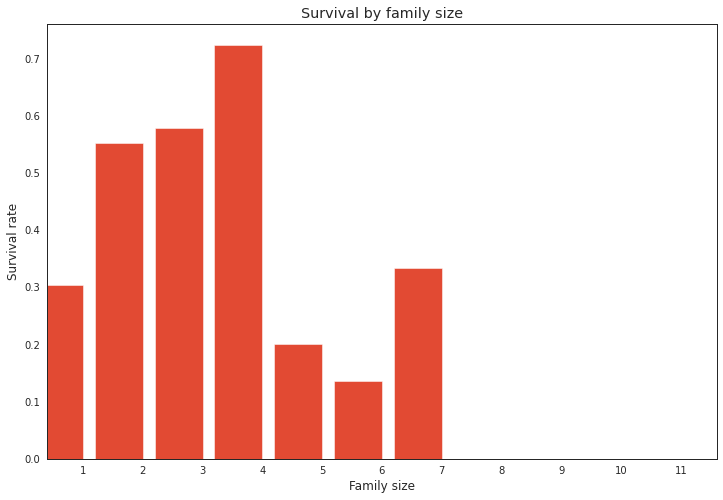

In [15]:
fam_survival = full_data[['FamilySize', 'Survived']].groupby('FamilySize').mean()
ind = np.arange(1, np.max(fam_survival.index.values) + 1) 
fam_survival = fam_survival.reindex(ind)
width = 0.8
fig, ax = plt.subplots()
survival_rates = fam_survival['Survived'].values
ax.bar(ind, survival_rates, width)
ax.set(xlabel='Family size', xticks=ind + width/2, xticklabels=ind.astype(int), xlim=[0.8, 12], ylabel='Survival rate', title='Survival by family size')
plt.show()

In [16]:
full_data['IsAlone'] = 1
full_data['IsAlone'].loc[full_data['FamilySize'] > 1] = 0
full_data['IsBigFamily'] = 1
full_data['IsBigFamily'].loc[full_data['FamilySize'] < 5] = 0

### create "IsYoung"
Being toung was important for survival. We will make "IsYoung" for better results.

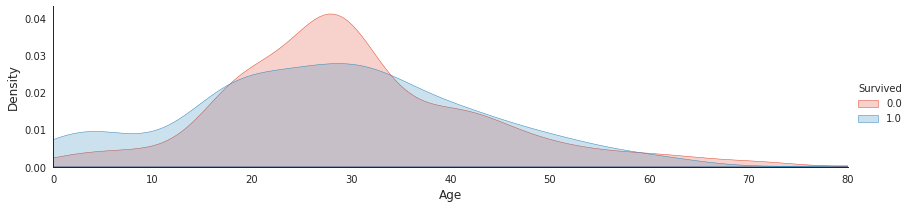

In [17]:
a = sns.FacetGrid( full_data, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , full_data['Age'].max()))
a.add_legend()

In [18]:
full_data['IsYoung'] = 0
full_data['IsYoung'].loc[full_data['Age'] < 16] = 1

In [19]:
full_data.groupby(['Pclass', 'IsYoung'])['Survived'].mean()

Pclass  IsYoung
1       0          0.623810
        1          0.833333
2       0          0.412121
        1          1.000000
3       0          0.214452
        1          0.435484
Name: Survived, dtype: float64

## 4. Converting 
*   non-numeric values : convert non-numeric values into numeric values  or drop if it is not needed, for further computation

*   "Age" & "Fare" : In order to prevent overfitting and reduce computation time, make a range for "Age" and "Fare" columns and make a new catagorized column "FareBin", "AgeBin"




In [20]:
full_data['FareBin'] = pd.qcut(full_data['Fare'], 4)
full_data['AgeBin'] = pd.cut(full_data['Age'].astype(int), 5)

In [21]:
label = LabelEncoder()
full_data['Sex_Code'] = label.fit_transform(full_data['Sex'])
full_data['Embarked_Code'] = label.fit_transform(full_data['Embarked'])
full_data['Title_Code'] = label.fit_transform(full_data['Title'])
full_data['AgeBin_Code'] = label.fit_transform(full_data['AgeBin'])
full_data['FareBin_Code'] = label.fit_transform(full_data['FareBin'])

full_data = full_data.drop(['PassengerId','Name','Sex','Ticket','Cabin','Embarked', 'Title','FareBin','AgeBin'],axis=1)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float64
 1   Pclass         1309 non-null   int64  
 2   Age            1309 non-null   float64
 3   SibSp          1309 non-null   int64  
 4   Parch          1309 non-null   int64  
 5   Fare           1308 non-null   float64
 6   FamilySize     1309 non-null   int64  
 7   IsAlone        1309 non-null   int64  
 8   IsBigFamily    1309 non-null   int64  
 9   IsYoung        1309 non-null   int64  
 10  Sex_Code       1309 non-null   int64  
 11  Embarked_Code  1309 non-null   int64  
 12  Title_Code     1309 non-null   int64  
 13  AgeBin_Code    1309 non-null   int64  
 14  FareBin_Code   1309 non-null   int64  
dtypes: float64(3), int64(12)
memory usage: 163.6 KB


In [22]:
full_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,IsBigFamily,IsYoung,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.00000,1309.000000,1309.000000
mean,0.383838,2.294882,29.517887,0.498854,0.385027,33.295479,1.883881,0.603514,0.062643,0.093965,0.644003,1.493506,1.92055,1.315508,1.488923
std,0.486592,0.837836,13.404461,1.041658,0.865560,51.758668,1.583639,0.489354,0.242413,0.291891,0.478997,0.814244,0.84037,0.809300,1.124202
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.00000,1.000000,0.000000
50%,0.000000,3.000000,28.318910,0.000000,0.000000,14.454200,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,2.00000,1.000000,1.000000
75%,1.000000,3.000000,36.500000,1.000000,0.000000,31.275000,2.000000,1.000000,0.000000,0.000000,1.000000,2.000000,2.00000,2.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,11.000000,1.000000,1.000000,1.000000,1.000000,2.000000,5.00000,4.000000,4.000000


## Spliting data into "train" and "submit"

In [23]:
train = full_data.loc[full_data.Survived.notnull()]
submit = full_data.loc[full_data.Survived.isnull()]

# Data Analysis


---


Visualizing training dataset  

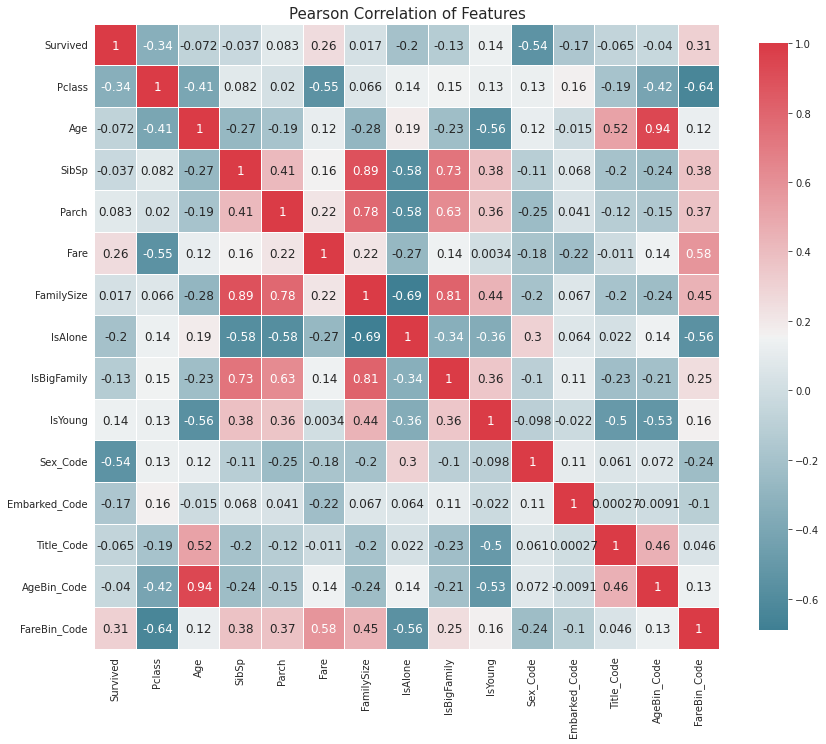

In [25]:
#@title Correlation Map
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train)

## Visualization

# Model Selection

---


We chose three models for our project. We will explain the reason in this section.

*   Decision Tree Classifier
*   Support Vector Classifier
*   Ensemble Modeling



In [26]:
train.groupby(['Pclass', 'Sex_Code', 'Embarked_Code','Survived']).size()

Pclass  Sex_Code  Embarked_Code  Survived
1       0         0              0.0           1
                                 1.0          42
                  1              1.0           1
                  2              0.0           2
                                 1.0          48
        1         0              0.0          25
                                 1.0          17
                  1              0.0           1
                  2              0.0          51
                                 1.0          28
2       0         0              1.0           7
                  1              1.0           2
                  2              0.0           6
                                 1.0          61
        1         0              0.0           8
                                 1.0           2
                  1              0.0           1
                  2              0.0          82
                                 1.0          15
3       0         0        

## Decision Tree Classifier
It is obvious that being **woman** or **young**, and **not in third class** are the most important pillars of survival. So we came to a conclusion that making a **dicision tree** is best for our project

<img src="https://github.com/nullPointerExcept10n/titanic-ML-project/blob/main/MyTree1.jpg?raw=true" width="690" height="300"><br>

Simply by asking a few questions we were able to reach 82% accuracy. Imagine its potential with hyperparameters 

## Support Vector Classifier (SVC)
SVC is a one of the strongest classifier we studied in our lecture. And according to the code we found SVC came second best for our dataset. 
[https://www.kaggle.com/code/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy](https://)

In [27]:
#@title Machine Learning Algorithm Selection Code
data1 = train
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
Target = ['Survived']
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True )
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.855056,0.828358,0.050311,0.109557
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.836704,0.826493,0.042552,0.043406
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.835581,0.826119,0.04427,0.052232
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.866854,0.822388,0.045936,0.067076
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.890449,0.820522,0.071755,0.017021
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.894757,0.81791,0.061271,0.090038
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.894757,0.81791,0.056594,0.127104
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.821348,0.814552,0.066423,0.069253
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.894757,0.813433,0.051541,0.002502
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.848502,0.810075,0.075996,0.002614


Text(0, 0.5, 'Algorithm')

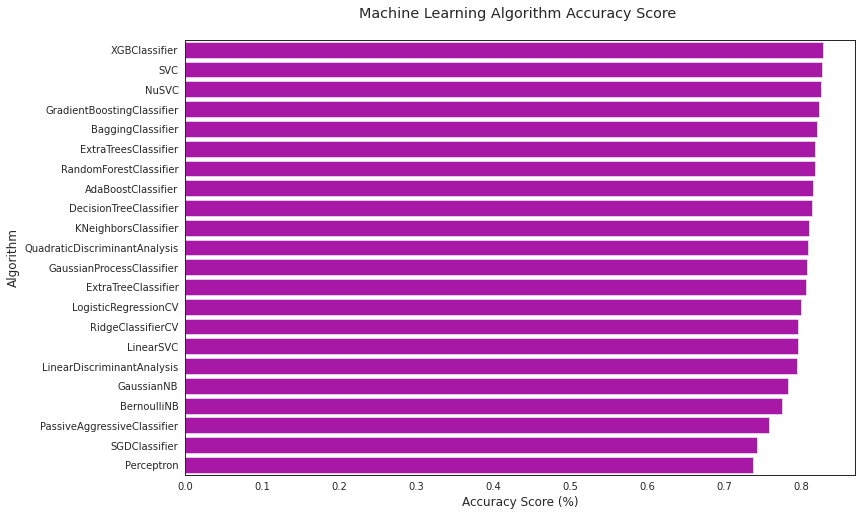

In [28]:
#@title Machine Leaning Selection Visualized
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## Ensemble Modeling
All codes that topped score without cheating in Kaggle competition chose Ensamble as their model. We found it inevitable for us to try ensamble modeling.

#Model Building

In [29]:
#@title Spliting train and test data
X = train.drop(['Survived'], axis = 1)
y = train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

##Decision Tree

In [30]:
#@title Cross-validation & RFE

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

data1 = X_train
data1['Survived'] = y_train


Target = ['Survived']
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code','IsAlone','IsBigFamily','IsYoung']
data1_xy_bin = Target + data1_x_bin

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2,4,6,8,10,None],
              'random_state': [0]
             }

dtree = tree.DecisionTreeClassifier(random_state = 0)

base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True )

print('BEFORE RFE Training Shape Old: ', data1[data1_x_bin].shape) 
print('BEFORE RFE Training Columns Old: ', data1[data1_x_bin].columns.values)

print("BEFORE RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

#transform x&y to reduced features and fit new model
X_rfe_dtree = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe_dtree], data1[Target], cv  = cv_split, return_train_score=True)

#print(dtree_rfe.grid_scores_)
print('AFTER RFE Training Shape New: ', data1[X_rfe_dtree].shape) 
print('AFTER RFE Training Columns New: ', X_rfe_dtree)

print("AFTER RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
rfe_tune_model.fit(data1[X_rfe_dtree], data1[Target])

print('AFTER RFE Tuned Parameters: ', rfe_tune_model.best_params_)
print("AFTER RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][rfe_tune_model.best_index_]*100)) 
print("AFTER RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][rfe_tune_model.best_index_]*100))
print("AFTER RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][rfe_tune_model.best_index_]*100*3))
print('-'*10)

BEFORE RFE Training Shape Old:  (623, 10)
BEFORE RFE Training Columns Old:  ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code' 'IsAlone' 'IsBigFamily' 'IsYoung']
BEFORE RFE Training w/bin score mean: 90.35
BEFORE RFE Test w/bin score mean: 79.09
BEFORE RFE Test w/bin score 3*std: +/- 7.19
----------
AFTER RFE Training Shape New:  (623, 5)
AFTER RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'FareBin_Code']
AFTER RFE Training w/bin score mean: 86.22
AFTER RFE Test w/bin score mean: 80.91
AFTER RFE Test w/bin score 3*std: +/- 7.86
----------
AFTER RFE Tuned Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'random_state': 0}
AFTER RFE Tuned Training w/bin score mean: 89.19
AFTER RFE Tuned Test w/bin score mean: 86.72
AFTER RFE Tuned Test w/bin score 3*std: +/- 5.82
----------


In [31]:
#@title Feature Importance
rf_grid = rfe_tune_model.best_estimator_
feature_importances = pd.DataFrame(rf_grid.feature_importances_,
                                   index = X_rfe_dtree,
                                    columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False).head(10)

,importance
Sex_Code,0.510765
FamilySize,0.202367
Pclass,0.198739
Title_Code,0.056689
FareBin_Code,0.031440


In [32]:
#@title Create & fit optimized dtree
dtree_optim = tree.DecisionTreeClassifier(random_state = 0, criterion= 'entropy', max_depth= 4)
dtree_optim.fit(data1[X_rfe_dtree], data1[Target])

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

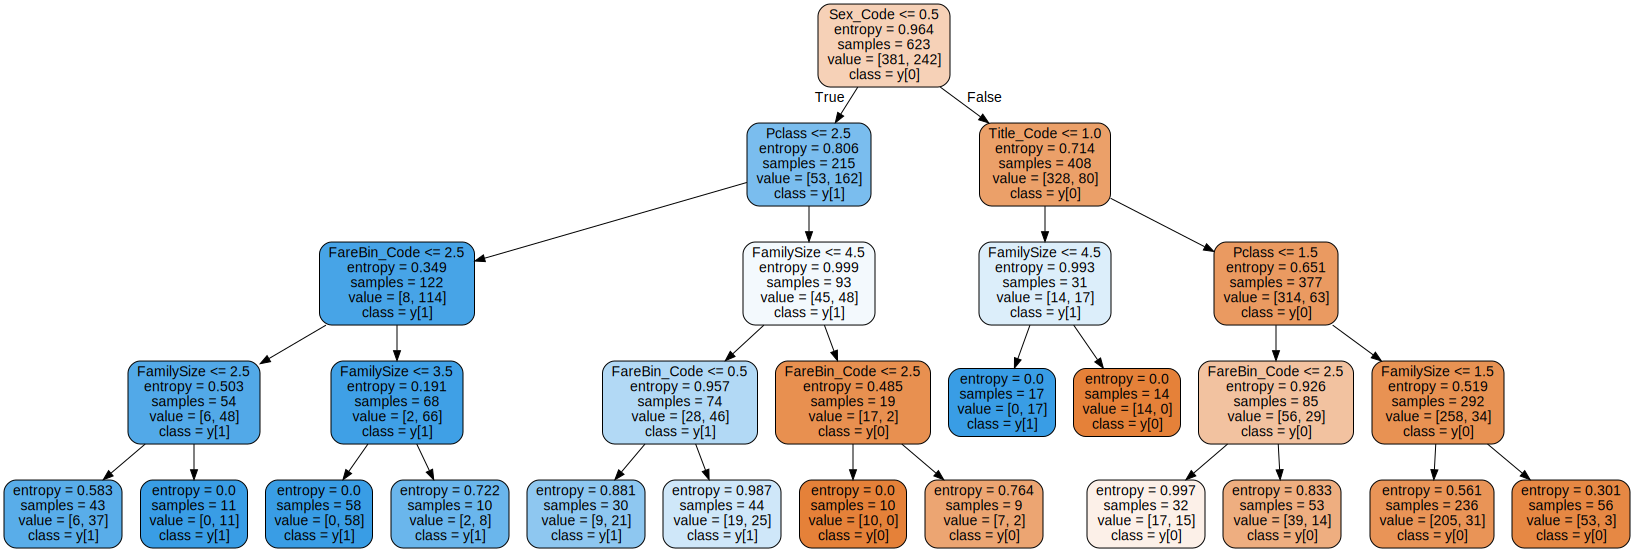

In [33]:
#@title Visualizing Dicision Tree
import graphviz 
dot_data = tree.export_graphviz(dtree_optim, out_file=None, 
                                feature_names = X_rfe_dtree, class_names = True,
                                filled = True, rounded = True)
graph = graphviz.Source(dot_data) 
graph

In [34]:
#@title Accuracy of Dicision tree

dtree_optim.score(X_test[X_rfe_dtree], y_test)

0.8283582089552238

##SVC

In [36]:
#@title Cross-validation & RFE
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

data1 = X_train
data1['Survived'] = y_train


param_grid = {  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5,10,100,1000], #default=1.0
            'gamma': [.1, .25, .5, .75, 1.0], #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': [0]
             } 

Target = ['Survived']
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code','IsAlone','IsBigFamily','IsYoung']
data1_xy_bin = Target + data1_x_bin

svc = SVC()
base_results = model_selection.cross_validate(svc, data1[data1_x_bin], data1[Target], cv  = cv_split,return_train_score=True)
svc.fit(data1[data1_x_bin], data1[Target])

print('BEFORE DT Parameters: ', svc.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



tune_model = model_selection.GridSearchCV(SVC(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split,return_train_score=True)
tune_model.fit(data1[data1_x_bin], data1[Target])


print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)



BEFORE DT Parameters:  {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
BEFORE DT Training w/bin score mean: 83.65
BEFORE DT Test w/bin score mean: 83.10
BEFORE DT Test w/bin score 3*std: +/- 9.22
----------
AFTER DT Parameters:  {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly', 'probability': True, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.53
AFTER DT Test w/bin score mean: 86.70
AFTER DT Test w/bin score 3*std: +/- 9.47
----------


In [37]:
#@title Create & fit optimized SVC
svc_optim = SVC(C= 1, decision_function_shape= 'ovo', gamma= 0.1,kernel= 'poly', probability= True, random_state= 0)
svc_optim.fit(data1[data1_x_bin], data1[Target])

SVC(C=1, decision_function_shape='ovo', gamma=0.1, kernel='poly',
    probability=True, random_state=0)

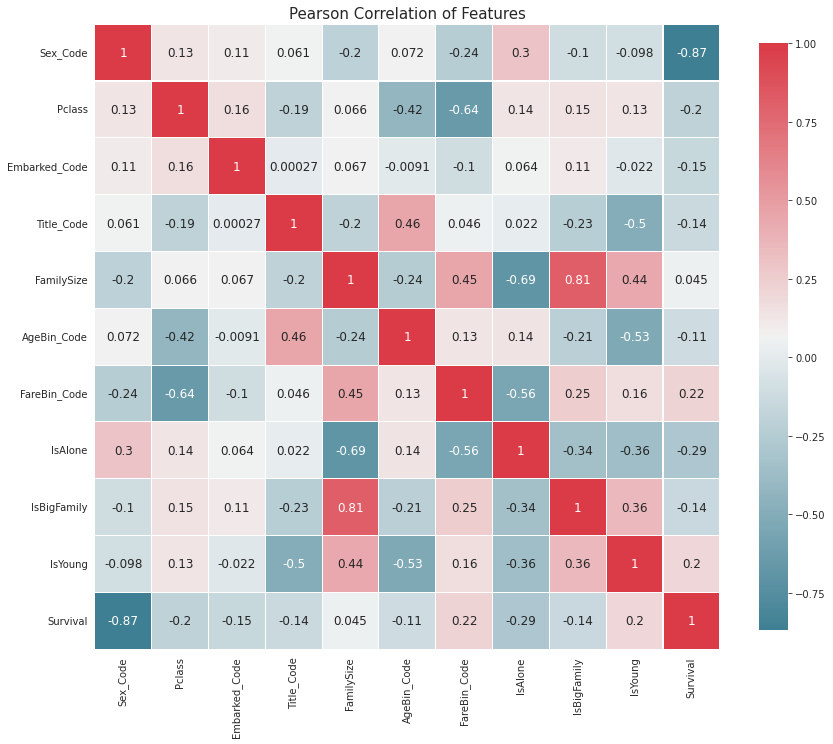

In [38]:
#@title Visualizing SVC
SVC_data = X[data1_x_bin]
SVC_data['Survival'] = svc_optim.predict(SVC_data)
correlation_heatmap(SVC_data)

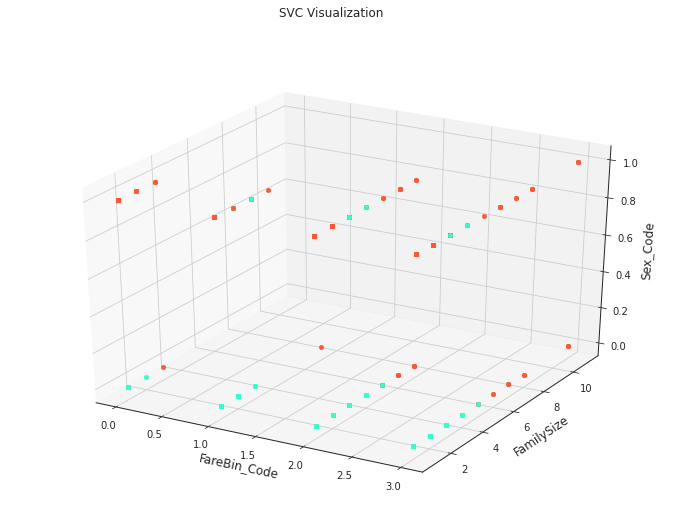

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = X['FareBin_Code']
y = X['FamilySize']
z = X['Sex_Code']
s = SVC_data['Survival']
for x_, y_, z_, s_ in zip(x,y,z,s):
    if s_ > 0.5:
        ax.scatter(x_,y_,z_,c='#33FFCE')
    else:
        ax.scatter(x_,y_,z_,c='#FF5733')
ax.set_xlabel("FareBin_Code")
ax.set_ylabel("FamilySize")
ax.set_zlabel("Sex_Code")
plt.suptitle('SVC Visualization')
plt.show()

In [40]:
#@title Accuracy of SVC
svc_optim.score(X_test[data1_x_bin], y_test)

0.8208955223880597

##Ensemble Modeling

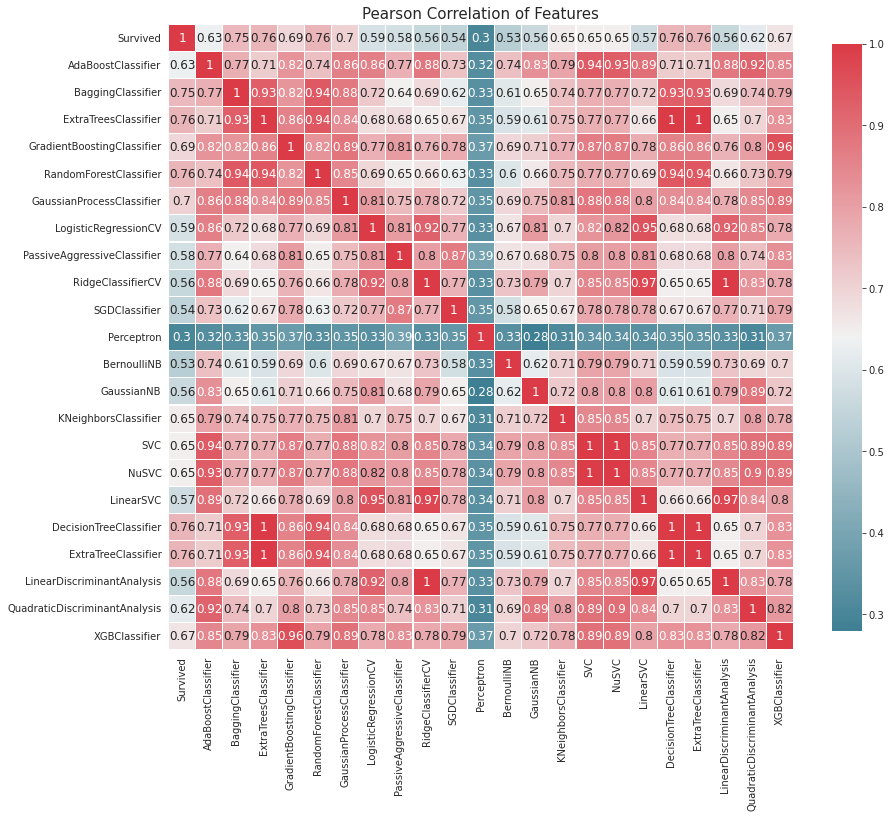

In [41]:
#@title Choosing ensemble methods
correlation_heatmap(MLA_predict)

In [42]:
#@title Create & cross-validate Hard vote & Soft Vote Ensemble model
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

data1 = X_train
data1['Survived'] = y_train


Target = ['Survived']
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code','IsAlone','IsBigFamily','IsYoung']
data1_xy_bin = Target + data1_x_bin

#why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),

    #NuSVC
    ('nus',NuSVC(probability=True, cache_size=1000)),

    #DecisionTreeClassifier
    ('dtc',tree.DecisionTreeClassifier()),


    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)
vote_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)
vote_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 87.96
Hard Voting Test w/bin score mean: 80.75
Hard Voting Test w/bin score 3*std: +/- 6.54
----------
Soft Voting Training w/bin score mean: 89.17
Soft Voting Test w/bin score mean: 80.86
Soft Voting Test w/bin score 3*std: +/- 7.79
----------


In [43]:
for x in vote_est:
  x[1].fit(X_train[data1_x_bin],y_train)

In [44]:
#@title Tuning Hyperparameter with GridSearchCV
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
            
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

            [{
            #NuSVC
            'nu': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0],
            'kernel': ['linear', 'rbf', 'sigmoid',],
            'gamma': ['auto', 'scale']
             }],
              
            [{
            #DecisionTreeClassifier
            'criterion': ['gini', 'entropy'],
            'max_depth': grid_max_depth,
            'random_state': grid_seed
             }],

          
    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)



The best parameter for AdaBoostClassifier is {'algorithm': 'SAMME.R', 'learning_rate': 0.05, 'n_estimators': 300, 'random_state': 0} with a runtime of 63.17 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 100, 'random_state': 0} with a runtime of 34.28 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 52.07 seconds.
The best parameter for GradientBoostingClassifier is {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 300.80 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 87.50 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 4.93 seconds.
The b

In [45]:
#@title Tuning Hard Vote & Soft Vote with grid

#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)
grid_hard.fit(data1[data1_x_bin], data1[Target])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv  = cv_split, return_train_score=True)
grid_soft.fit(data1[data1_x_bin], data1[Target])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)



Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 85.09
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.67
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 7.29
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 84.99
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 83.37
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 7.81
----------


In [46]:
#@title Ensemble Model Accuracy
print(vote_soft.score(X_test[data1_x_bin],y_test))
print(vote_hard.score(X_test[data1_x_bin],y_test))

0.835820895522388
0.832089552238806


# Model Evaluation

In [47]:
from sklearn.metrics import confusion_matrix
x_dtree = train[X_rfe_dtree]
x_svc = train[data1_x_bin]  
y = train["Survived"]
y_pred_dtree = dtree_optim.predict(x_dtree)
y_pred_svc = svc_optim.predict(x_svc)

# 종속 변수와 예측 결과로 혼동 행렬 생성
cm1 = confusion_matrix(y, y_pred_dtree)
print(cm1)

cm2 = confusion_matrix(y, y_pred_svc)
print(cm2)

cm3 = confusion_matrix(train["Survived"], vote_hard.predict(train[data1_x_bin]))
print(cm3)

cm4 = confusion_matrix(train["Survived"], vote_soft.predict(train[data1_x_bin]))
print(cm4)

[[492  57]
 [ 90 252]]
[[492  57]
 [ 90 252]]
[[504  45]
 [ 86 256]]
[[501  48]
 [ 72 270]]


In [48]:
from sklearn.metrics import confusion_matrix
x_svc = train[data1_x_bin] 
y = train["Survived"]
y_pred_svc = svc_optim.predict(x_svc)

cm2 = confusion_matrix(y, y_pred_svc)
print(cm2)

[[492  57]
 [ 90 252]]


In [49]:
from sklearn.metrics import confusion_matrix

# 종속 변수와 예측 결과로 혼동 행렬 생성
cm3 = confusion_matrix(train["Survived"], vote_hard.predict(train[data1_x_bin]))
print(cm3)


[[504  45]
 [ 86 256]]


In [50]:
from sklearn.metrics import confusion_matrix

# 종속 변수와 예측 결과로 혼동 행렬 생성
cm4 = confusion_matrix(train["Survived"], vote_soft.predict(train[data1_x_bin]))
print(cm4)

[[501  48]
 [ 72 270]]


In [51]:
from sklearn.metrics import precision_score
print(precision_score(y, y_pred_dtree))
print(precision_score(y, y_pred_svc))
print(precision_score(train["Survived"], vote_hard.predict(train[data1_x_bin])))
print(precision_score(train["Survived"], vote_soft.predict(train[data1_x_bin])))

0.8155339805825242
0.8155339805825242
0.8504983388704319
0.8490566037735849


In [52]:
from sklearn.metrics import precision_score
print(precision_score(y, y_pred_svc))

0.8155339805825242


In [53]:
from sklearn.metrics import precision_score
print(precision_score(train["Survived"], vote_hard.predict(train[data1_x_bin])))

0.8504983388704319


In [54]:
from sklearn.metrics import precision_score
print(precision_score(train["Survived"], vote_soft.predict(train[data1_x_bin])))

0.8490566037735849


In [55]:
from sklearn.metrics import recall_score
print(recall_score(y, y_pred_dtree))
print(recall_score(y, y_pred_svc))
print(recall_score(train["Survived"], vote_hard.predict(train[data1_x_bin])))
print(recall_score(train["Survived"], vote_soft.predict(train[data1_x_bin])))

0.7368421052631579
0.7368421052631579
0.7485380116959064
0.7894736842105263


In [56]:
from sklearn.metrics import f1_score
print(f1_score(y, y_pred_dtree))
print(f1_score(y, y_pred_svc))
print(f1_score(train["Survived"], vote_hard.predict(train[data1_x_bin])))
print(f1_score(train["Survived"], vote_soft.predict(train[data1_x_bin])))

0.7741935483870966
0.7741935483870966
0.7962674961119751
0.8181818181818182


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    # x축을 threshold, y축을 정밀도, 재현율로 그래프 그리기
    plt.figure(figsize=(8, 6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:thresholds_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[:thresholds_boundary], linestyle=':', label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    plt.xlim()
    plt.xlabel('thresholds')
    plt.ylabel('precision & recall value')
    plt.legend()
    plt.grid()

오차행렬:
 [[492  57]
 [ 90 252]]

정확도: 0.8350
정밀도: 0.8155
재현율: 0.7368
F1: 0.7742
AUC: 0.8165


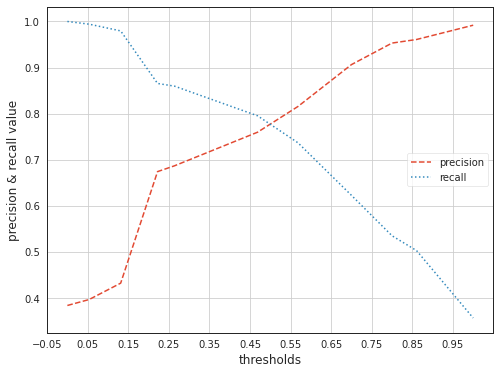

In [58]:
# Decision Tree
pred_dtree = dtree_optim.predict(x_dtree)
pred_proba_dtree = dtree_optim.predict_proba(x_dtree)[:,1]
get_clf_eval(y,pred_dtree)
precision_recall_curve_plot(y, pred_proba_dtree)

오차행렬:
 [[492  57]
 [ 90 252]]

정확도: 0.8350
정밀도: 0.8155
재현율: 0.7368
F1: 0.7742
AUC: 0.8165


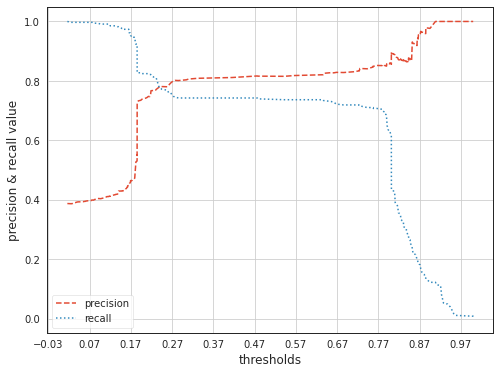

In [59]:
# SVC
pred_svc = svc_optim.predict(x_svc)
pred_proba_svc = svc_optim.predict_proba(x_svc)[:,1]
get_clf_eval(y,pred_svc)
precision_recall_curve_plot(y, pred_proba_svc)

오차행렬:
 [[501  48]
 [ 72 270]]

정확도: 0.8653
정밀도: 0.8491
재현율: 0.7895
F1: 0.8182
AUC: 0.8510


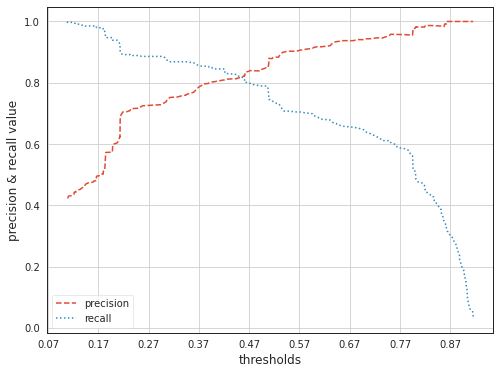

In [60]:
# Ensemble vote soft
pred_evs = vote_soft.predict(train[data1_x_bin])
pred_proba_evs = vote_soft.predict_proba(train[data1_x_bin])[:,1]
get_clf_eval(y,pred_evs)
precision_recall_curve_plot(y, pred_proba_evs)

In [61]:
# Ensemble vote hard 불가능!!
# https://www.inflearn.com/questions/24703/voting-%EB%AA%A8%EB%8D%B8%EB%A1%9C-roc%EA%B3%A1%EC%84%A0-%EA%B7%B8%EB%A6%AC%EA%B8%B0
pred_evh = vote_hard.predict(train[data1_x_bin])
pred_proba_evh = vote_hard.predict_proba(train[data1_x_bin])[:,1]
get_clf_eval(y,pred_evh)
precision_recall_curve_plot(y, pred_proba_evh)

AttributeError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, dtree_optim.predict_proba(x_dtree)[:,1]))
print(roc_auc_score(y, svc_optim.predict_proba(x_svc)[:,1]))
print(roc_auc_score(y,vote_soft.predict_proba(train[data1_x_bin])[:,1]))
print(roc_auc_score(y,vote_hard.predict_proba(train[data1_x_bin])[:,1]))
